In [1]:
import os
import warnings
import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

from matplotlib import gridspec
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
#from xgboost import XGBClassifier


from sklearn import tree

from os import system
from IPython.display import Image


warnings.filterwarnings('ignore')                                       # Ignore/Do not display warnings

main_data = pd.read_csv('backpain.csv')

In [2]:
main_data.head(10)

,pelvic_incidence,pelvic tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Status
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,Abnormal
5,40.250200,13.921907,25.124950,26.328293,130.327871,2.230652,0.789993,29.3230,12.0036,10.40462,-1.512209,9.6548,Abnormal
6,53.432928,15.864336,37.165934,37.568592,120.567523,5.988551,0.198920,13.8514,10.7146,11.37832,-20.510434,25.9477,Abnormal
7,45.366754,10.755611,29.038349,34.611142,117.270067,-10.675871,0.131973,28.8165,7.7676,7.60961,-25.111459,26.3543,Abnormal
8,43.790190,13.533753,42.690814,30.256437,125.002893,13.289018,0.190408,22.7085,11.4234,10.59188,-20.020075,40.0276,Abnormal
9,36.686353,5.010884,41.948751,31.675469,84.241415,0.664437,0.367700,26.2011,8.7380,14.91416,-1.702097,21.4320,Abnormal


In [3]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          310 non-null    float64
 1   pelvic tilt               310 non-null    float64
 2   lumbar_lordosis_angle     310 non-null    float64
 3   sacral_slope              310 non-null    float64
 4   pelvic_radius             310 non-null    float64
 5   degree_spondylolisthesis  310 non-null    float64
 6   pelvic_slope              310 non-null    float64
 7   Direct_tilt               310 non-null    float64
 8   thoracic_slope            310 non-null    float64
 9   cervical_tilt             310 non-null    float64
 10  sacrum_angle              310 non-null    float64
 11  scoliosis_slope           310 non-null    float64
 12  Status                    310 non-null    object 
dtypes: float64(12), object(1)
memory usage: 31.6+ KB


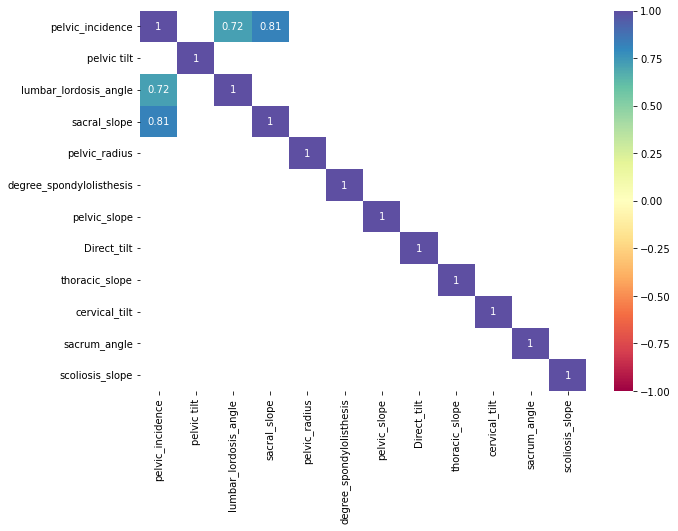

In [4]:
# variables that have more than 0.7 correlation
df = main_data.copy()
plt.figure(figsize=(10,7))
sns.heatmap(df.corr()[df.corr()>0.7],annot = True,vmax = 1, vmin = -1, cmap='Spectral');

In [5]:
'''
Input:
Pandas DataFrame

Output:
Displays DataFrame structure 
(columns, nulls and non nulls counts and percentage highlighing columns with most number of nulls)

Retunrs:
N/A
'''
def info(dataFrame):
    print(f"{dataFrame.shape[0]} Rows x {dataFrame.shape[1]} Columns")
    nulls_series      = dataFrame.isna().sum()         # Get a series counting number of empty values for each column
    nonnulls_series   = dataFrame.notnull().sum()      # Get a series counting number of non empty valuesfor each column 
    nulls_percentage  = ((nulls_series * 100)/(nulls_series + nonnulls_series)).astype(float)
    column_datatypes  = dataFrame.dtypes               # Get a series containing data types for each column 
    
    series_arr    = [nulls_series, nonnulls_series, nulls_percentage, column_datatypes]
    col_names_arr = ["Nulls", "Non-Nulls","Nulls %", "Type"]
    
    nulls_count_df = pd.concat(
        objs = series_arr,
        axis = 1,
        keys = col_names_arr, 
        sort = True)
    
    cm = sns.light_palette("red", as_cmap=True)
    display(nulls_count_df.style.background_gradient(cmap=cm, subset=pd.IndexSlice[:, ['Nulls %']]).format(formatter={('Nulls %'): "{:.2f}%"})) 
    

'''
Input:
Target type and a list of feature names.

Output:
Convert all features provided in 'column_names' to Target type provided in 'toType'

Returns:
modifies main original data frame and returns nothing.
'''
def ConvertColTo(toType, column_names=np.nan, df = np.nan):
    for col_name in column_names:
        df[col_name] = df[col_name].astype(toType)


'''
Input:
N/A

Output:
Go through each categorial column and print unique values for that column.

Retunrs:
N/A
'''
def CountUniqueValues(col_names):
    for col_name in col_names:
        print(f"======================='{col_name}'==================")
        for unique_col_value in  main_data[col_name].unique().tolist():
            total_count = main_data[col_name].count()
            unique_values_count = main_data[main_data[col_name] == unique_col_value][col_name].count()
            percentage = str(round((unique_values_count/total_count) * 100, 2))
            print(f"{unique_col_value} \t: {unique_values_count} ({percentage}%)")
        print(f"=========================================================\n")

In [6]:
catgry_col_names = df.select_dtypes(include=['object']).columns.tolist()
ConvertColTo('category', catgry_col_names, df)

In [7]:
CountUniqueValues(catgry_col_names)

======================='Status'==================
Abnormal 	: 210 (67.74%)
Normal 	: 100 (32.26%)



In [8]:
replace_struct = {
    "Status"      : {"Normal": 0, "Abnormal": 1},
}

df = df.replace(replace_struct)
df.head(10)

,pelvic_incidence,pelvic tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Status
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,0.744503,12.5661,14.5386,15.30468,-28.658501,43.5123,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,0.415186,12.8874,17.5323,16.78486,-25.530607,16.1102,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,0.474889,26.8343,17.4861,16.65897,-29.031888,19.2221,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,0.369345,23.5603,12.7074,11.42447,-30.470246,18.8329,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,0.543360,35.4940,15.9546,8.87237,-16.378376,24.9171,1
5,40.250200,13.921907,25.124950,26.328293,130.327871,2.230652,0.789993,29.3230,12.0036,10.40462,-1.512209,9.6548,1
6,53.432928,15.864336,37.165934,37.568592,120.567523,5.988551,0.198920,13.8514,10.7146,11.37832,-20.510434,25.9477,1
7,45.366754,10.755611,29.038349,34.611142,117.270067,-10.675871,0.131973,28.8165,7.7676,7.60961,-25.111459,26.3543,1
8,43.790190,13.533753,42.690814,30.256437,125.002893,13.289018,0.190408,22.7085,11.4234,10.59188,-20.020075,40.0276,1
9,36.686353,5.010884,41.948751,31.675469,84.241415,0.664437,0.367700,26.2011,8.7380,14.91416,-1.702097,21.4320,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          310 non-null    float64
 1   pelvic tilt               310 non-null    float64
 2   lumbar_lordosis_angle     310 non-null    float64
 3   sacral_slope              310 non-null    float64
 4   pelvic_radius             310 non-null    float64
 5   degree_spondylolisthesis  310 non-null    float64
 6   pelvic_slope              310 non-null    float64
 7   Direct_tilt               310 non-null    float64
 8   thoracic_slope            310 non-null    float64
 9   cervical_tilt             310 non-null    float64
 10  sacrum_angle              310 non-null    float64
 11  scoliosis_slope           310 non-null    float64
 12  Status                    310 non-null    int64  
dtypes: float64(12), int64(1)
memory usage: 31.6 KB


In [18]:
# Functions to calculate different metrics

def DisplayConfusionMatrix(model, y_actual, labels=[1,0]):
    y_predict = model.predict(x_test)
    confusion_matrix = metrics.confusion_matrix(y_actual, y_predict, labels=[0, 1])
    confusion_matix_df = pd.DataFrame(
        confusion_matrix,
        index   = [i for i in ["Actual No", "Actual Yes"]],
        columns = [i for i in ["Predicted - No", "Predicted - Yes"]])
    
    group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]
    group_percetages = ["{0:.2%}".format(value) for value in confusion_matrix.flatten()/np.sum(confusion_matrix)]
    
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percetages)]
    labels = np.array(labels).reshape(2, 2)
    plt.figure(figsize= (10,7))
    sns.heatmap(confusion_matix_df, annot=labels,fmt='')
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    
def GetMetricsScore(model):
    
    pred_train = model.predict(x_train)
    pred_test  = model.predict(x_test)
    
    train_accuracy = model.score(x_train, y_train)
    test_accuracy  = model.score(x_test, y_test)
    
    train_recall = metrics.recall_score(y_train, pred_train)
    test_recall  = metrics.recall_score(y_test, pred_test)
    
    train_precision = metrics.precision_score(y_train, pred_train)
    test_precision  = metrics.precision_score(y_test, pred_test)

    f1_score_train = 2 * ((train_precision * train_recall)/(train_precision + train_recall))
    f1_score_test = 2 * ((test_precision * test_recall)/(test_precision + test_recall))
    
    return {
        'Accuracy_Test'   : test_accuracy,
        'Accuracy_Train'  : train_accuracy,
        'Recall_Test'     : test_recall,
        'Recall_Train'    : train_recall,
        'Precision_Test'  : test_precision,
        'Precision_Train' : train_precision,
        'F1_Score_Train'  : f1_score_train,
        'F1_Score_Test'   : f1_score_test
    }

def DisplayImportance(model):
    gini_importances = pd.DataFrame(model.feature_importances_, columns=["Imp"], index=x_train.columns).sort_values(by = "Imp")
    print(gini_importances)
    
def DisplayImportanceChart(model):
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(12, 12))
    plt.title('Feature Importance')
    plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
    plt.yticks(range(len(indices)), [list(X.columns)[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    
def PlotTree(model, size = [20, 30]):
    plt.figure(figsize=(size[0],size[1]))
    tree.plot_tree(model, feature_names=feature_names, filled=True, fontsize=9, node_ids=True, class_names=True)
    plt.show()
    
def PrintCoeficients(model):
    coefs = pd.DataFrame(
        np.append(model.coef_, model.intercept_),
        index=x_train.columns.tolist() + ["Intercept"],
        columns=["Coefficients"],
    )

    coefs.sort_values('Coefficients')

In [13]:
X = df.drop("Status", axis=1)
Y = df.pop("Status")
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [14]:
print(x_train.shape, x_test.shape)

(217, 12) (93, 12)


In [15]:
print(y_test.value_counts(normalize=True))

1    0.709677
0    0.290323
Name: Status, dtype: float64


In [16]:
logistic_reg_model = LogisticRegression()
logistic_reg_model.fit(x_train,y_train)

LogisticRegression()

In [19]:
rf_score = GetMetricsScore(logistic_reg_model)
pprint.pprint(rf_score)

{'Accuracy_Test': 0.8924731182795699,
 'Accuracy_Train': 0.8433179723502304,
 'F1_Score_Test': 0.923076923076923,
 'F1_Score_Train': 0.881118881118881,
 'Precision_Test': 0.9375,
 'Precision_Train': 0.8873239436619719,
 'Recall_Test': 0.9090909090909091,
 'Recall_Train': 0.875}


In [21]:
coefs = pd.DataFrame(
    np.append(logistic_reg_model.coef_, logistic_reg_model.intercept_),
    index=x_train.columns.tolist() + ["Intercept"],
    columns=["Coefficients"],
)

coefs.sort_values('Coefficients')

,Coefficients
pelvic_radius,-0.089799
sacral_slope,-0.070545
lumbar_lordosis_angle,-0.020201
scoliosis_slope,-0.014293
Direct_tilt,-0.010797
sacrum_angle,0.006773
thoracic_slope,0.013921
pelvic_incidence,0.014534
pelvic tilt,0.085079
degree_spondylolisthesis,0.140103


In [28]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    recall_score,
    accuracy_score,
    precision_score,
    f1_score,
)

score_DT = []
for i in range(1,9):
    dTree = DecisionTreeClassifier(max_depth=i,criterion = 'gini', random_state=1)
    dTree.fit(x_train, y_train)
    pred = dTree.predict(x_train)
    case = {'Depth':i,'Recall':recall_score(y_train,pred)}
    score_DT.append(case)

In [30]:
pprint.pprint(score_DT)

[{'Depth': 1, 'Recall': 0.6875},
 {'Depth': 2, 'Recall': 0.8888888888888888},
 {'Depth': 3, 'Recall': 0.8888888888888888},
 {'Depth': 4, 'Recall': 0.9583333333333334},
 {'Depth': 5, 'Recall': 0.9652777777777778},
 {'Depth': 6, 'Recall': 0.9930555555555556},
 {'Depth': 7, 'Recall': 0.9861111111111112},
 {'Depth': 8, 'Recall': 1.0}]


In [43]:
dTree = DecisionTreeClassifier()
dTree.fit(x_train, y_train)

DecisionTreeClassifier()

In [44]:
dTree_score = GetMetricsScore(dTree)
pprint.pprint(dTree_score)

{'Accuracy_Test': 0.7956989247311828,
 'Accuracy_Train': 1.0,
 'F1_Score_Test': 0.8455284552845528,
 'F1_Score_Train': 1.0,
 'Precision_Test': 0.9122807017543859,
 'Precision_Train': 1.0,
 'Recall_Test': 0.7878787878787878,
 'Recall_Train': 1.0}


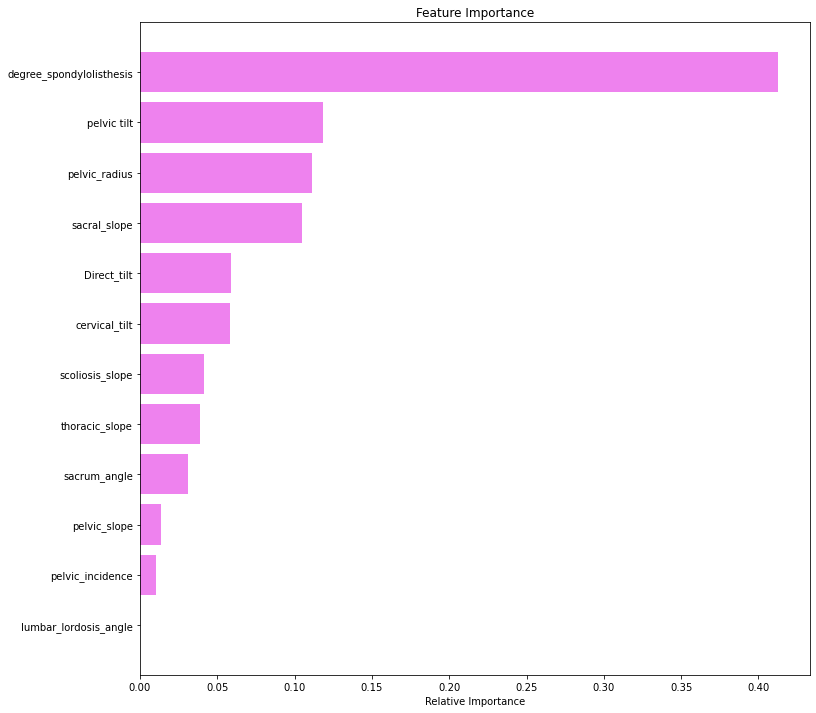

In [32]:
DisplayImportanceChart(dTree)

In [45]:

# choose the type of classifier
dTree_Model_tuned = DecisionTreeClassifier(random_state=1, criterion= 'gini')

# Grid of params to choose from
parameters = {
    "max_depth": [5,10,15, None],
    "criterion": ['gini','entropy'],
    "splitter": ['best','random']
}

# type of score used to compare paramter combinations
acc_scorer =metrics.make_scorer(metrics.recall_score)

# run the grid search
grid_obj = GridSearchCV(dTree_Model_tuned, parameters, scoring=acc_scorer, cv=3)
grid_obj = grid_obj.fit(x_train, y_train)

# set the clf to the best combination of parameters
dTree_Model_tuned = grid_obj.best_estimator_

# fit the best algorithm to the data
dTree_Model_tuned.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=1,
                       splitter='random')

In [47]:
dTree_Model_tuned_score = GetMetricsScore(dTree_Model_tuned)


In [48]:
pprint.pprint({"default":dTree_score, "tuned": dTree_Model_tuned_score})

{'default': {'Accuracy_Test': 0.7956989247311828,
             'Accuracy_Train': 1.0,
             'F1_Score_Test': 0.8455284552845528,
             'F1_Score_Train': 1.0,
             'Precision_Test': 0.9122807017543859,
             'Precision_Train': 1.0,
             'Recall_Test': 0.7878787878787878,
             'Recall_Train': 1.0},
 'tuned': {'Accuracy_Test': 0.7419354838709677,
           'Accuracy_Train': 0.967741935483871,
           'F1_Score_Test': 0.8153846153846153,
           'F1_Score_Train': 0.9757785467128027,
           'Precision_Test': 0.828125,
           'Precision_Train': 0.9724137931034482,
           'Recall_Test': 0.803030303030303,
           'Recall_Train': 0.9791666666666666}}


In [50]:
clf = DecisionTreeClassifier(random_state=1)
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Training DecisionTreeClassifiers at different ccp_alpha values
clfs = []
for ccp_alpha in ccp_alphas:
 clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
 clf.fit(x_train, y_train)
 clfs.append(clf)
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

# Finding recall score on training and test set
recall_train=[]
for clf in clfs:
 pred_train=clf.predict(x_train)
 values_train=metrics.recall_score(y_train,pred_train)
 recall_train.append(values_train)
recall_test=[]
for clf in clfs:
 pred_test=clf.predict(x_test)
 values_test=metrics.recall_score(y_test,pred_test)
 recall_test.append(values_test)

# Finding the best ccp_alpha value
index_best_model = np.argmax(recall_test)
best_model = clfs[index_best_model]
print(best_model)

DecisionTreeClassifier(ccp_alpha=0.029595494111623127, random_state=1)


In [ ]:
dTree_Model

In [10]:
rf = RandomForestClassifier(random_state=1)
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=1)

In [11]:
rf_score = GetMetricsScore(rf)
pprint.pprint(rf_score)

{'Accuracy_Test': 1.0,
 'Accuracy_Train': 1.0,
 'F1_Score_Test': 1.0,
 'F1_Score_Train': 1.0,
 'Precision_Test': 1.0,
 'Precision_Train': 1.0,
 'Recall_Test': 1.0,
 'Recall_Train': 1.0}


In [12]:
# bagging classifier with base estimator  =Logistic Regression
bag_lr = BaggingClassifier(random_state=1, base_estimator = LogisticRegression(random_state = 1))
bag_lr.fit(x_train, y_train)

BaggingClassifier(base_estimator=LogisticRegression(random_state=1),
                  random_state=1)

In [13]:
bag_lr_score = GetMetricsScore(bag_lr)
pprint.pprint(bag_lr_score)

{'Accuracy_Test': 0.9841269841269841,
 'Accuracy_Train': 0.9897260273972602,
 'F1_Score_Test': 0.9166666666666666,
 'F1_Score_Train': 0.9361702127659574,
 'Precision_Test': 0.8461538461538461,
 'Precision_Train': 0.9565217391304348,
 'Recall_Test': 1.0,
 'Recall_Train': 0.9166666666666666}


In [35]:
print("Bagging")
bag_lr = BaggingClassifier(random_state=1, base_estimator = LogisticRegression(random_state = 1))
bag_lr.fit(x_train, y_train)
bag_lr_score = GetMetricsScore(bag_lr)
pprint.pprint(bag_lr_score)

print("Forest")
forest = RandomForestClassifier()
forest.fit(x_train, y_train)
forest_score = GetMetricsScore(forest)
pprint.pprint(forest_score)

Bagging
{'Accuracy_Test': 0.9841269841269841,
 'Accuracy_Train': 0.9897260273972602,
 'F1_Score_Test': 0.9166666666666666,
 'F1_Score_Train': 0.9361702127659574,
 'Precision_Test': 0.8461538461538461,
 'Precision_Train': 0.9565217391304348,
 'Recall_Test': 1.0,
 'Recall_Train': 0.9166666666666666}
Forest
{'Accuracy_Test': 1.0,
 'Accuracy_Train': 1.0,
 'F1_Score_Test': 1.0,
 'F1_Score_Train': 1.0,
 'Precision_Test': 1.0,
 'Precision_Train': 1.0,
 'Recall_Test': 1.0,
 'Recall_Train': 1.0}


In [40]:
scores = []
for i in range(1,6):
    bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=1,max_depth = i),random_state=1)
    bag.fit(x_train, y_train)
    bag_lr_score = GetMetricsScore(bag)
    print(i)
    pprint.pprint(f"F1 Train : {bag_lr_score['F1_Score_Train']}")

1
'F1 Train : 0.8400000000000001'
2
'F1 Train : 0.9787234042553191'
3
'F1 Train : 0.9787234042553191'
4
'F1 Train : 0.9787234042553191'
5
'F1 Train : 1.0'


In [41]:
# Adaboost classifier
X_train = x_train
abc = AdaBoostClassifier(random_state=1)
abc.fit(X_train, y_train)

# GradientBoost classifier
gbm = GradientBoostingClassifier(random_state=1)
gbm.fit(X_train, y_train)

#XGBoost classifier
xgb = XGBClassifier(random_state=1, eval_metric = 'logloss')
xgb.fit(X_train, y_train)

# predicting on training set
abc_predict = abc.predict(X_train)
gbm_predict = gbm.predict(X_train)
xgb_predict = xgb.predict(X_train)

# Checking model performance
print('ABC')
score = GetMetricsScore(abc)
pprint.pprint(score)

print('GBM')
score = GetMetricsScore(gbm)
pprint.pprint(score)

print('XGB')
score = GetMetricsScore(xgb)
pprint.pprint(score)

ABC
{'Accuracy_Test': 1.0,
 'Accuracy_Train': 1.0,
 'F1_Score_Test': 1.0,
 'F1_Score_Train': 1.0,
 'Precision_Test': 1.0,
 'Precision_Train': 1.0,
 'Recall_Test': 1.0,
 'Recall_Train': 1.0}
GBM
{'Accuracy_Test': 0.9920634920634921,
 'Accuracy_Train': 1.0,
 'F1_Score_Test': 0.9565217391304348,
 'F1_Score_Train': 1.0,
 'Precision_Test': 0.9166666666666666,
 'Precision_Train': 1.0,
 'Recall_Test': 1.0,
 'Recall_Train': 1.0}
XGB
{'Accuracy_Test': 1.0,
 'Accuracy_Train': 1.0,
 'F1_Score_Test': 1.0,
 'F1_Score_Train': 1.0,
 'Precision_Test': 1.0,
 'Precision_Train': 1.0,
 'Recall_Test': 1.0,
 'Recall_Train': 1.0}


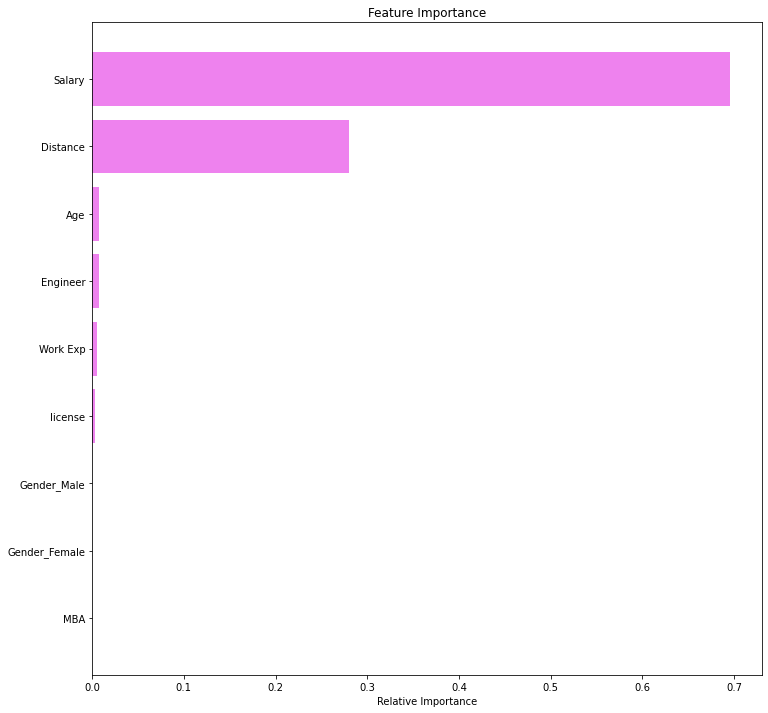

In [22]:
DisplayImportanceChart(gbm)

In [23]:
# Training first model
gbm1 = GradientBoostingClassifier(random_state=1, n_estimators=50, learning_rate = 0.01 )
gbm1.fit(X_train,y_train)

# Training second model
gbm2 = GradientBoostingClassifier(random_state=1, n_estimators=100, learning_rate = 0.01 )
gbm2.fit(X_train,y_train)

# Training third model
gbm3 = GradientBoostingClassifier(random_state=1, n_estimators=400, learning_rate = 0.01 )
gbm3.fit(X_train,y_train)

print('gbm1')
score = GetMetricsScore(gbm1)
pprint.pprint(score)

print('gbm2')
score = GetMetricsScore(gbm2)
pprint.pprint(score)

print('gbm3')
score = GetMetricsScore(gbm3)
pprint.pprint(score)

gbm1
{'Accuracy_Test': 0.9126984126984127,
 'Accuracy_Train': 0.9178082191780822,
 'F1_Score_Test': nan,
 'F1_Score_Train': nan,
 'Precision_Test': 0.0,
 'Precision_Train': 0.0,
 'Recall_Test': 0.0,
 'Recall_Train': 0.0}
gbm2
{'Accuracy_Test': 0.9761904761904762,
 'Accuracy_Train': 0.9965753424657534,
 'F1_Score_Test': 0.88,
 'F1_Score_Train': 0.9787234042553191,
 'Precision_Test': 0.7857142857142857,
 'Precision_Train': 1.0,
 'Recall_Test': 1.0,
 'Recall_Train': 0.9583333333333334}
gbm3
{'Accuracy_Test': 0.9761904761904762,
 'Accuracy_Train': 1.0,
 'F1_Score_Test': 0.88,
 'F1_Score_Train': 1.0,
 'Precision_Test': 0.7857142857142857,
 'Precision_Train': 1.0,
 'Recall_Test': 1.0,
 'Recall_Train': 1.0}


In [42]:
estimators = [('DT',DecisionTreeClassifier(random_state=1)),
 ('BAG',BaggingClassifier(random_state=1))]

# Training stacking classifier
clf = StackingClassifier(estimators = estimators, final_estimator = RandomForestClassifier(random_state=1))
clf.fit(X_train, y_train)

StackingClassifier(estimators=[('DT', DecisionTreeClassifier(random_state=1)),
                               ('BAG', BaggingClassifier(random_state=1))],
                   final_estimator=RandomForestClassifier(random_state=1))

In [43]:
y_pred = clf.predict(X_train)

In [44]:
score = GetMetricsScore(clf)
pprint.pprint(score)

{'Accuracy_Test': 0.9920634920634921,
 'Accuracy_Train': 0.9828767123287672,
 'F1_Score_Test': 0.9523809523809523,
 'F1_Score_Train': 0.8837209302325582,
 'Precision_Test': 1.0,
 'Precision_Train': 1.0,
 'Recall_Test': 0.9090909090909091,
 'Recall_Train': 0.7916666666666666}


In [29]:
estimators = [('GBM',GradientBoostingClassifier(random_state=1)),
 ('ABC',AdaBoostClassifier(random_state=1)),
 ]

# Training stacking classifier
clf = StackingClassifier(estimators = estimators, final_estimator = XGBClassifier(random_state=1, eval_metric='logloss'))
clf.fit(X_train, y_train)

score = GetMetricsScore(clf)
pprint.pprint(score)

{'Accuracy_Test': 0.9761904761904762,
 'Accuracy_Train': 1.0,
 'F1_Score_Test': 0.88,
 'F1_Score_Train': 1.0,
 'Precision_Test': 0.7857142857142857,
 'Precision_Train': 1.0,
 'Recall_Test': 1.0,
 'Recall_Train': 1.0}
